In [17]:
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import dask
import scipy
import glob
from tqdm import tqdm
from datetime import datetime, timedelta
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import os
import skimage

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import Stamen
from cartopy.io.img_tiles import MapboxTiles
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings("ignore")

import imageio
import geojson
import requests

from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib import font_manager as fm

%matplotlib inline

In [18]:
# 1) Register your new fonts explicitly
font_dir = os.path.expanduser("~/.local/share/fonts")
for path in glob.glob(os.path.join(font_dir, "lm*.otf")):
    fm.fontManager.addfont(path)
for path in glob.glob(os.path.join(font_dir, "cmu*.otf")):
    fm.fontManager.addfont(path)
# Global LaTeX-y defaults
mpl.rcParams.update({
    "text.usetex": False,              # keep mathtext (no TeX required)
    "mathtext.fontset": "cm",          # Computer Modern math
    "axes.unicode_minus": False,

    # Default family = serif (like LaTeX)
    "font.family": "serif",

    # Families mapped to your installed fonts (with sensible fallbacks)
    "font.serif": ["LMRoman10", "CMU Serif", "DejaVu Serif"],
    "font.sans-serif": ["LMSans10", "CMU Sans Serif", "DejaVu Sans"],
    "font.monospace": ["LMMono10", "CMU Typewriter Text", "DejaVu Sans Mono"],
})


### Load Data

In [19]:
initial_detections_df = pd.read_csv('data/initial_detections.csv',)
initial_detections_df['timestamp'] = pd.to_datetime(initial_detections_df['Launch_JD'], unit='D', origin='julian')

## Literature comparison

In [20]:
len(initial_detections_df)

27

In [21]:
falcon_9 = initial_detections_df[initial_detections_df['LV_Type'] == 'Falcon 9']
# remove outlier
mean,std,median = falcon_9['ime_at_t0'].mean(), falcon_9['ime_at_t0'].std(), falcon_9['ime_at_t0'].median()
# mean,std,median = falcon_9['ime'].mean(), falcon_9['ime'].std(), falcon_9['ime'].median()

mean,std,median

(2140.5069837044116, 1143.3434695854257, 1753.71566819192)

In [22]:
len(falcon_9)

19

In [23]:
mean*0.45

963.2281426669853

In [24]:
falcon_9['ime_at_t0'].describe()
# falcon_9['ime'].describe()

count      19.000000
mean     2140.506984
std      1143.343470
min       570.487641
25%      1303.967144
50%      1753.715668
75%      2847.323019
max      4928.640086
Name: ime_at_t0, dtype: float64

In [25]:
# previous literature estimates
pradon = 6800
desain_brady = 644
ryan = 997.17
barker = 1017.52

In [26]:
((mean-barker) / (barker))*100

110.36510178713064

In [27]:
((mean-ryan) / (ryan))*100

114.6581810227355

In [28]:
((mean-desain_brady) / (desain_brady))*100

232.3768608236664

# Figure 3

In [29]:
falcon_9 = initial_detections_df[initial_detections_df['LV_Type'] == 'Falcon 9']

In [30]:
grouped = initial_detections_df.groupby('LV_Type')
bar_df = pd.DataFrame({
    'Count': grouped['ime_at_t0'].count(),
    'ime': grouped['ime_at_t0'].mean(),
    'ime_min': grouped['ime_at_t0'].min(),
    'ime_max': grouped['ime_at_t0'].max(),
    # 'ime': grouped['ime'].mean(),
    # 'ime_min': grouped['ime'].min(),
    # 'ime_max': grouped['ime'].max(),
    'Launch_Mass': grouped['Launch_Mass'].mean()
}).round(2)
bar_sorted = bar_df.sort_values('ime', ascending=False)
norm = plt.Normalize(np.log10(bar_sorted['ime'].min()), 
                     np.log10(bar_sorted['ime'].max()+1000))

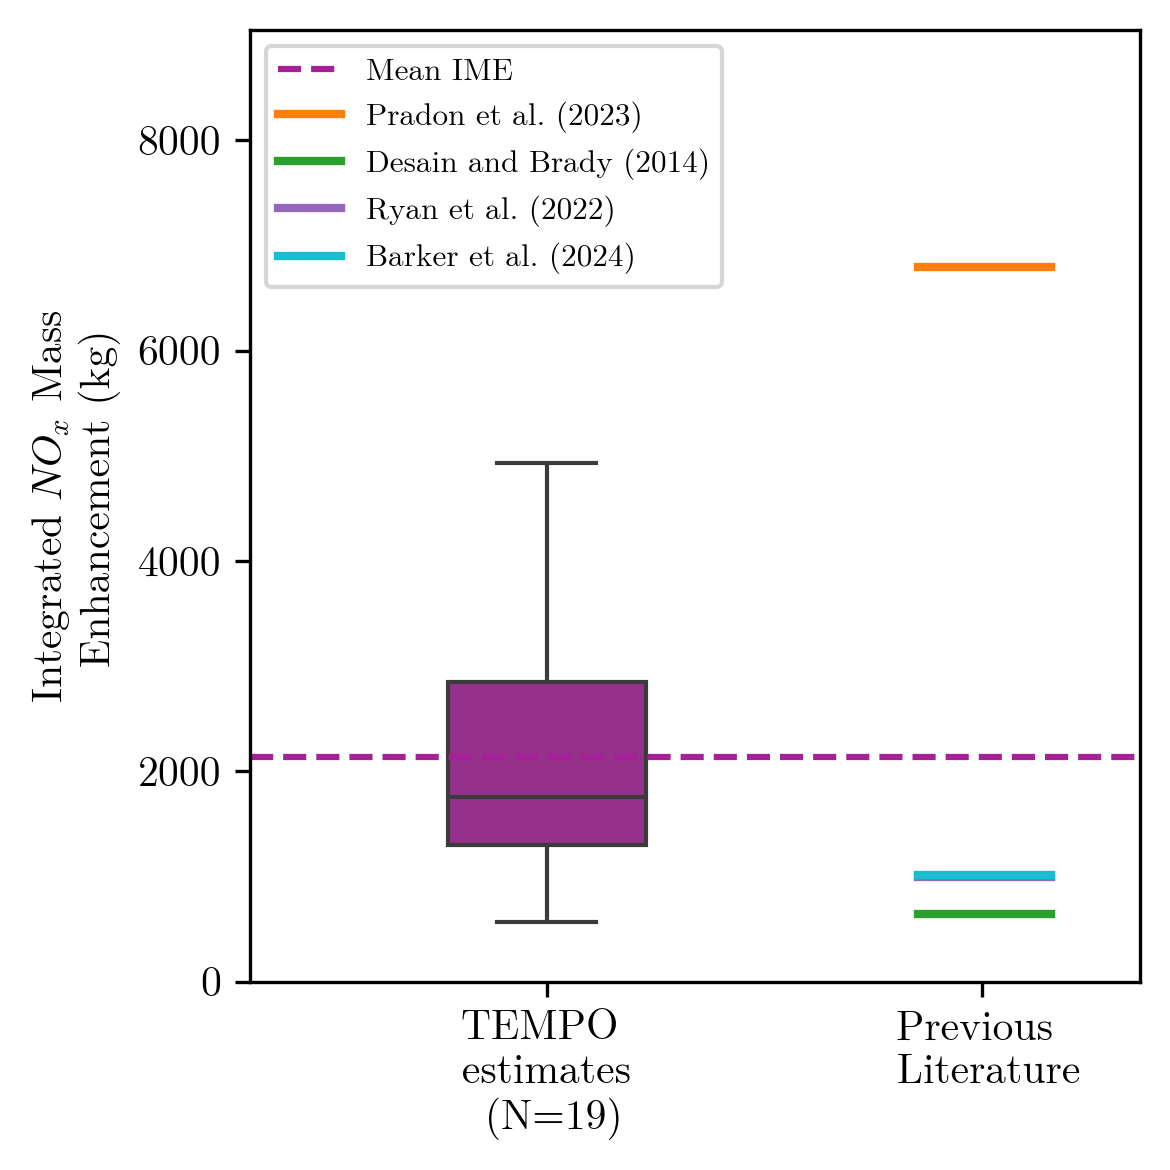

In [31]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
# sns.boxenplot(y=detections_df['ime'], ax=ax, color='tab:blue', width=0.5, k_depth=3)
# sns.boxenplot(y=initial_detections_df['ime_at_t0'], ax=ax, color=plt.cm.plasma(norm(np.log10((bar_df['ime'].quantile(0.5))))), width=0.5, k_depth=4, flier_kws={'marker': 'd', 'facecolor': plt.cm.plasma(norm(np.log10((bar_df['ime'].quantile(0.5))))), 'edgecolor': plt.cm.plasma(norm(np.log10((bar_df['ime'].quantile(0.5))))),})
sns.boxplot(y=falcon_9['ime_at_t0'], ax=ax, color=plt.cm.plasma(norm(np.log10((bar_df['ime'].quantile(0.5))))), width=0.2, flierprops={'marker': 'd', 'color': plt.cm.plasma(norm(np.log10((bar_df['ime'].quantile(0.5)))))})

# sns.violinplot(y=initial_detections_df['ime_at_t0'], ax=ax, cut=0, color=plt.cm.plasma(norm(np.log10((bar_df['ime'].quantile(0.5))))), width=0.5, bw=0.6)
# horizontal line for the mean
ax.axhline(mean, color=plt.cm.plasma(norm(np.log10((bar_df['ime'].quantile(0.5))))), linestyle='--', label='Mean IME', linewidth=1.5)
# horizontal line for the median
# ax.axhline(detections_df['ime'].median(), color='tab:orange', linestyle='--', label='Median IME', linewidth=1)

# # plot and label symbols for previous literature estimates
# ax.scatter([0.4], [pradon, ], color='tab:orange', marker='_', label='Pradon et al. (2023)', s=250)
# ax.scatter([0.4], [desain_brady, ], color='tab:green', marker='_', label='Desain and Brady (2023)', s=250)
# ax.scatter([0.4], [ryan,], color='tab:purple', marker='_', label='Ryan et al. (2022)', s=250)
# ax.scatter([0.4], [barker, ], color='tab:cyan', marker='_', label='Barker et al. (2024)', s=250)

# plot and label horizontal lines for previous literature estimates
ax.axhline(pradon, xmin=0.75, xmax=0.9, color='tab:orange', linestyle='-', linewidth=2, label='Pradon et al. (2023)')
ax.axhline(desain_brady, xmin=0.75, xmax=0.9, color='tab:green', linestyle='-', linewidth=2, label='Desain and Brady (2014)')
ax.axhline(ryan, xmin=0.75, xmax=0.9, color='tab:purple', linestyle='-', linewidth=2, label='Ryan et al. (2022)')
ax.axhline(barker, xmin=0.75, xmax=0.9, color='tab:cyan', linestyle='-', linewidth=2, label='Barker et al. (2024)')

ax.set_xlim(-0.3, 0.6)
ax.set_ylim(-0, 9050)

ax.set_ylabel('Integrated $NO_x$ Mass \n Enhancement (kg)')

ax.set_xticks([0, 0.44], labels=[f'TEMPO \n estimates \n (N={len(falcon_9)})', 'Previous \n Literature'])

ax.legend(loc='upper left', fontsize=7.5, frameon=True)

fig.tight_layout()
# save figure
plt.savefig(f'figures/fig_3.png', dpi=300)